### **Introduction**

In this personal project, I aim to develop a deep learning model capable of classifying different types of heartbeats based on ECG signals. The implementation choices, including model selection, denoising techniques, and preprocessing strategies, will be thoroughly justified throughout this Jupyter Notebook.

To provide a structured approach, I have divided the project into distinct phases, each corresponding to a dedicated chapter. This workflow is inspired by the guidelines presented in [_Yaqoob Ansari et al._](https://www.frontiersin.org/journals/physiology/articles/10.3389/fphys.2023.1246746/full), particularly Chapter 7, where the authors outline a methodology suitable for researchers new to ECG classification.

The project follows the following structured workflow:
1. **Database Selection Stage**: in this section, I discuss the dataset chosen for the project, outlining its characteristics and relevance to the task.
2. **Preprocessing Stage**: this section addresses the types of noise commonly found in ECG signals and presents the techniques employed to enhance the quality of the input data.
3. **Segmentation Stage**: here, I explore methods for partitioning ECG signals into smaller, meaningful segments to facilitate the learning process of the model.
4. **Feature Extraction Stage**: I assess whether additional features can be derived from the ECG data or whether the raw segmented signals provide sufficient information for classification.
5. **Classification Stage**: This section details the design and implementation of a deep learning model aimed at solving the heartbeat classification task.
6. **Evaluation Stage**: I analyze the model’s performance using standard evaluation metrics, providing insights into its effectiveness and limitations.
7. **Conclusions**: finally, I summarize the key takeaways from this project, discussing the main challenges encountered and the strategies adopted to overcome them. Additionally, I reflect on the model's limitations and propose potential improvements for future research.

This structured approach ensures clarity and coherence throughout the project, facilitating both implementation and interpretability.

### **Database selection stage**

For this project, I will use the MIT-BIH Arrhythmia Database, a collection of 30-minute ECG recordings from 47 patients, collected between 1975 and 1979. The dataset includes recordings from both healthy individuals and patients with heart conditions; however, it is slightly imbalanced, with a predominance of patients exhibiting cardiac abnormalities.


The first step is download the dataset from the [official website.](https://www.physionet.org/content/mitdb/1.0.0/)

The dataset documentation can be found [here.](https://archive.physionet.org/physiobank/database/html/mitdbdir/mitdbdir.htm)


To correctly read and process the data, I will use the [WFDB (Waveform Database) library,](https://wfdb.io/) a widely used tool for handling physiological signal datasets.

In [1]:
import os
try:
    import wfdb
except ImportError:
    os.system("pip install wfdb")
    import wfdb

In [61]:
try:
  import torchmetrics
  from torchmetrics import Accuracy
  from torchmetrics import Recall
except ImportError:
  os.system("pip install torchmetrics")
  import torchmetrics
  from torchmetrics import Accuracy
  from torchmetrics import Recall

In [4]:
import torch
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import scipy as sp
import random
from tqdm import tqdm # Progress bar
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
from torch.utils.data import random_split
from torch.optim.lr_scheduler import LinearLR, ReduceLROnPlateau
import seaborn as sns
from pathlib import Path

print(f"PyTorch version: {torch.__version__}")
print(f"wfdb version: {wfdb.__version__}")

PyTorch version: 2.6.0+cpu
wfdb version: 4.2.0


In [10]:
# Global variable to run code on colab or locally
COLAB = False

In [11]:
if COLAB:
  from google.colab import drive
  drive.mount('/content/gdrive')

#### **Let's visualise!**

I will use the [`plot_wfdb` method](https://wfdb.readthedocs.io/en/latest/plot.html) to visualize the ECG recording of patient #100.

For a clearer visualization, I will focus on the first 1000 samples of the ECG signal.

Since the MIT-BIH Arrhythmia Database has a sampling frequency of 360 Hz, this subset corresponds to approximately 2.78 seconds of the patient's ECG recording.

The duration in seconds is given by:
$$\text{seconds} = \frac{\text{number of samples}}{\text{sampling frequency}} = \frac{1000}{360} \approx 2.78 \text{ seconds}$$

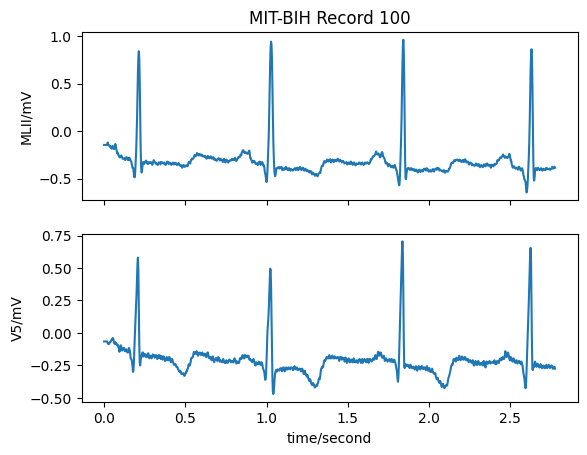

In [12]:
if COLAB:
  patient_path = "/content/gdrive/MyDrive/mit-bih-arrhythmia-database-1.0.0/100"
else:
  patient_path = "mit-bih-arrhythmia-database-1.0.0/100"
patient_record = wfdb.rdrecord(patient_path, sampto=1000)
wfdb.plot_wfdb(patient_record, title='MIT-BIH Record 100', time_units='seconds') # Plots the ECG

The first four heartbeats of patient #100 can be clearly observed.

A single ECG beat is divided according to the following labels:
* **P Label:** refers to the P wave, the first wave generated in the heartbeat cycle. It corresponds to the depolarization of the atria.
* **Q Label:** refers to the Q wave, the initial downward deflection following the P wave. It represents the initial depolarization of the interventricular septum.
* **R Label:** refers to the R wave, the largest upward deflection in the ECG cycle, corresponding to the depolarization of the main mass of the ventricles.
* **S Label:** refers to the S wave, the downward deflection following the R wave, representing the final phase of ventricular depolarization.
* **T Label:** refers to the T wave, which represents the repolarization (or recovery) of the ventricles.

Below is the diagram of an ECG beat with its labels including intervals and segments.
![title](img/electrocardiogram_diagram.png)

For more information, see the [Wikipedia page on Electrocardiography](https://en.wikipedia.org/wiki/Electrocardiography).

Returning to the WFDB library, using `__dict__` returns a dictionary containing all the ECG data. This dictionary provides a wealth of information:
* The first section contains metadata, including:
    * The patient number (`record_name`)
    * The number of leads recorded (`n_sig`)
    * Additional details about the patient
* The middle section stores the ECG data, specifically the voltages of the leads. In this case, there are two leads:
    * MLII (Modified Lead II)
    * V5 (Precordial Lead V5)
  
  These are two different types of ECG signals obtained from distinct lead configurations.
    * More info about leads [here](https://www.washingtonhra.com/ekg-monitoring/12-lead-electrocardiogram-ekg.php)
* The last section provides details about voltage values, units, data format, and other technical specifications.

In [13]:
print(patient_record.__dict__)

{'record_name': '100', 'n_sig': 2, 'fs': 360, 'counter_freq': None, 'base_counter': None, 'sig_len': 1000, 'base_time': None, 'base_date': None, 'comments': ['69 M 1085 1629 x1', 'Aldomet, Inderal'], 'sig_name': ['MLII', 'V5'], 'p_signal': array([[-0.145, -0.065],
       [-0.145, -0.065],
       [-0.145, -0.065],
       ...,
       [-0.385, -0.26 ],
       [-0.375, -0.26 ],
       [-0.385, -0.275]]), 'd_signal': None, 'e_p_signal': None, 'e_d_signal': None, 'file_name': ['100.dat', '100.dat'], 'fmt': ['212', '212'], 'samps_per_frame': [1, 1], 'skew': [None, None], 'byte_offset': [None, None], 'adc_gain': [200.0, 200.0], 'baseline': [1024, 1024], 'units': ['mV', 'mV'], 'adc_res': [11, 11], 'adc_zero': [1024, 1024], 'init_value': [995, 1011], 'checksum': [44119, 64923], 'block_size': [0, 0]}


This data can also be accessed via dot notation:

In [14]:
print(f"Patient number: {patient_record.record_name}")
print(f"Leads: {patient_record.sig_name}")
print(f"ECG data: {patient_record.p_signal}")

Patient number: 100
Leads: ['MLII', 'V5']
ECG data: [[-0.145 -0.065]
 [-0.145 -0.065]
 [-0.145 -0.065]
 ...
 [-0.385 -0.26 ]
 [-0.375 -0.26 ]
 [-0.385 -0.275]]


In [15]:
print(f"First 50 values of the first lead for patient 100: \n {patient_record.p_signal[:50, 0]}\n")
print(f"patient_record.p_signal's type: {type(patient_record.p_signal)} \npatient_record.p_signal's length: {len(patient_record.p_signal)}")

First 50 values of the first lead for patient 100: 
 [-0.145 -0.145 -0.145 -0.145 -0.145 -0.145 -0.145 -0.145 -0.12  -0.135
 -0.145 -0.15  -0.16  -0.155 -0.16  -0.175 -0.18  -0.185 -0.17  -0.155
 -0.175 -0.18  -0.19  -0.18  -0.155 -0.135 -0.155 -0.19  -0.205 -0.235
 -0.225 -0.245 -0.25  -0.26  -0.275 -0.275 -0.275 -0.265 -0.255 -0.265
 -0.275 -0.29  -0.29  -0.29  -0.29  -0.285 -0.295 -0.305 -0.285 -0.275]

patient_record.p_signal's type: <class 'numpy.ndarray'> 
patient_record.p_signal's length: 1000


Most, but not all, of the patients' heartbeats have been labeled by medical experts. These labels, which will be referred to as annotations, are stored in the .atr file:

In [16]:
if COLAB:
  drive.mount('/content/gdrive')
  annotations = wfdb.rdann('/content/gdrive/MyDrive/mit-bih-arrhythmia-database-1.0.0/100', 'atr')  # path to the .atr file
else:
  annotations = wfdb.rdann('mit-bih-arrhythmia-database-1.0.0/100', 'atr')  # path to the .atr file

print("First 20 annotations (or symbols) for Record 100:\n", annotations.symbol[: 20])

First 20 annotations (or symbols) for Record 100:
 ['+', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'A', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N']


The term **annotations** is more appropriate than **labels** because these files contain not only heartbeat classifications but also medical comments, observations, and additional clinically relevant information about the beat.

Therefore, some preprocessing will be required to extract only the annotations relevant to the classification task.

### **Preprocessing stage**

Data preprocessing is a fundamental step when working with raw and unstructured datasets. It involves cleaning and organizing data to improve its quality and make it suitable for machine learning and deep learning models.

I will split the preprocessing in 2 main steps:
* **Filtering**: ECG signals, like any other signal, are susceptible to noise from various sources. In particular, ECG noise includes power line interference, muscle artifacts, and baseline wander. To enhance the signal quality, it is necessary applied filters. Typically, these types of noise are found in the low-frequency band of the frequency spectrum.
* **Segmentation**: it will be covered in the next chapter

The first step is apply an high pass filter to remove the low frequencies that are not related to an ECG signal.
* The [ECG's frequency range](https://www.gehealthcare.com/insights/article/a-guide-to-ecg-signal-filtering#:~:text=ECG%20frequencies%20typically%20fall%20in,with%20the%20ECG%20frequency%20range.) is between 0.5Hz - 150Hz

To achieve this, I will design a high-pass filter that allows frequencies above 0.5 Hz to pass while attenuating those below this threshold.
For the implementation, I will use the Butterworth filter provided by the [SciPy](https://scipy.org/) library, which offers a comprehensive set of tools for signal processing. The Butterworth filter is particularly suitable for this task due to its maximally flat frequency response in the passband, ensuring minimal distortion of the retained frequencies.
* More information about the SciPy butter function [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.butter.html)

In [17]:
def high_pass_filter(original_signal, cutoff_frequency=0.5, sampling_rate=360, order=3):
  """
  Applies a high-pass Butterworth filter to the input signal.

  Parameters:
  - original_signal (array-like): the input signal to be filtered
  - cutoff_frequency (float, optional): the cutoff frequency of the high-pass filter in Hz (default 0.5 Hz)
  - sampling_rate (float, optional): the sampling rate of the signal in Hz (default 360 Hz)
  - order (int, optional): the order of the Butterworth filter (default 3)

  Returns:
  - filtered_signal (array-like): the filtered signal after applying the high-pass filter
  """
  nyquist = 0.5 * sampling_rate # Nyquist frequency
  normal_cutoff = cutoff_frequency / nyquist # Normalize the cutoff frequency with respect to the Nyquist frequency
  b, a = sp.signal.butter(order, normal_cutoff, btype='highpass', analog=False)
  filtered_signal = sp.signal.filtfilt(b, a, original_signal)
  return filtered_signal

In [18]:
def get_frequency_spectrum(signal, freq_to, freq_from):
  """
  Computes the frequency spectrum of a given signal using the Fast Fourier Transform (FFT)
    and returns the amplitude of frequency components within a specified range.

    Parameters:
    - signal (array-like): the input signal to be analyzed.
    - freq_to (float): the lower bound of the frequency range to consider (in Hz).
    - freq_from (float): the upper bound of the frequency range to consider (in Hz).

    Returns:
    - filtered_frequencies (array-like): the frequencies within the specified range.
    - filtered_fft_data (array-like): the corresponding amplitude of the frequency components.
  """
  sampling_rate = 360  # Sampling rate in Hz

  # Calculate FFT of the signal
  fft_data = np.fft.fft(signal)  # Select the first lead
  frequencies = np.fft.fftfreq(len(signal), d=1/sampling_rate)

  # Find the indices corresponding to the positive frequencies
  positive_frequencies = frequencies[:len(frequencies)//2]
  positive_fft_data = np.abs(fft_data[:len(fft_data)//2])

  # Filter for frequencies between the input range
  freq_range = (positive_frequencies >= freq_to) & (positive_frequencies <= freq_from)
  filtered_frequencies = positive_frequencies[freq_range]
  filtered_fft_data = positive_fft_data[freq_range]
  return filtered_frequencies, filtered_fft_data

In [19]:
def low_pass_filter(original_signal, cutoff_freq=150, sampling_rate=360, order=3):
  """
  Applies a low-pass Butterworth filter to the input signal.

  Parameters:
  - original_signal (array-like): the input signal to be filtered
  - cutoff_frequency (float, optional): the cutoff frequency of the high-pass filter in Hz (default 0.5 Hz)
  - sampling_rate (float, optional): the sampling rate of the signal in Hz (default 360 Hz)
  - order (int, optional): the order of the Butterworth filter (default 3)

  Returns:
  - filtered_signal (array-like): the filtered signal after applying the low-pass filter
  """
  nyquist = 0.5 * sampling_rate # Nyquist frequency
  normal_cutoff = cutoff_freq / nyquist # Normalize the cutoff frequency with respect to the Nyquist frequency
  b, a = sp.signal.butter(order, normal_cutoff, btype='low', analog=False)
  filtered_data = sp.signal.filtfilt(b, a, original_signal)
  return filtered_data

In [20]:
def notch_filter(signal, notch_frequency=60, quality_factor=30, sampling_rate=360):
  """
  Applies a notch filter to remove a specific frequency from the input signal.

  Parameters:
  - signal (array-like): the input signal to be filtered
  - notch_frequency (float, optional): the target frequency to be removed, in Hz (default 60 Hz)
  - quality_factor (float, optional): the quality factor of the notch filter, which determines
    the filter's bandwidth (default 30).
  - sampling_rate (float, optional): the sampling rate of the signal in Hz (default 360 Hz)

  Returns:
  - filtered_signal (array-like): the filtered signal after removing the specified frequency.
  """
  # Calculate the notch filter coefficients
  b, a = sp.signal.iirnotch(notch_frequency / (sampling_rate / 2), quality_factor)

  # Filters the signal to remove 60Hz interference
  return sp.signal.filtfilt(b, a, signal)

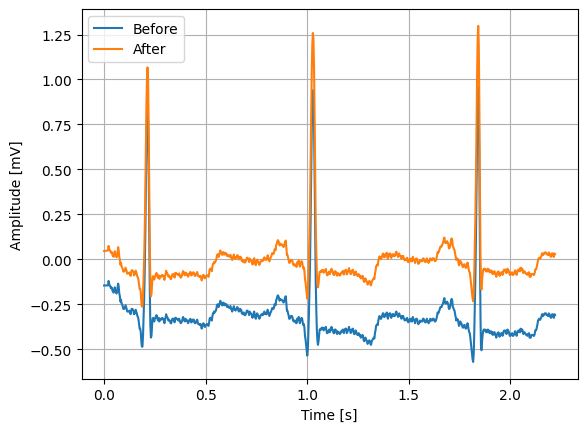

Average amplitude of the original signal: -0.3062989769230769
Average amplitude of the filtered signal: 1.1819206769761296e-06


In [21]:
# Fetch the complete signal
patient_record = wfdb.rdrecord(patient_path)

# Removing baseline wandering
t = np.arange(len(patient_record.p_signal[:,0][:800])) / 360  # Creating the time axis
filtered_high_pass_signal = high_pass_filter(patient_record.p_signal[:,0])
plt.plot(t, patient_record.p_signal[:,0][:800])
plt.plot(t, filtered_high_pass_signal[:800])
plt.xlabel("Time [s]")
plt.ylabel("Amplitude [mV]")
plt.grid(True)
plt.legend(("Before", "After"))
plt.show()
print(f"Average amplitude of the original signal: {patient_record.p_signal[:,0].mean()}")
print(f"Average amplitude of the filtered signal: {filtered_high_pass_signal.mean()}")

The average amplitude of the original signal is -0.3062989769230769, indicating the presence of a DC component.
* More information about [DC bias here](https://en.wikipedia.org/wiki/DC_bias)

The DC bias is not strictly a form of noise but rather an artifact, primarily caused by factors such as electrode polarization, amplifier offset, or external interferences. Removing this bias is essential prior to further signal processing, as it ensures a centered signal and facilitates accurate analysis.

After applying the high-pass filter, the average amplitude of the filtered signal is 1.1819206769761296e-06, which is effectively close to zero. This demonstrates that the high-pass filter successfully removed the DC component, as expected.

To assess whether the filter has also eliminated noise in the frequency range between 0 Hz and 0.5 Hz, we can analyze the frequency spectrum:

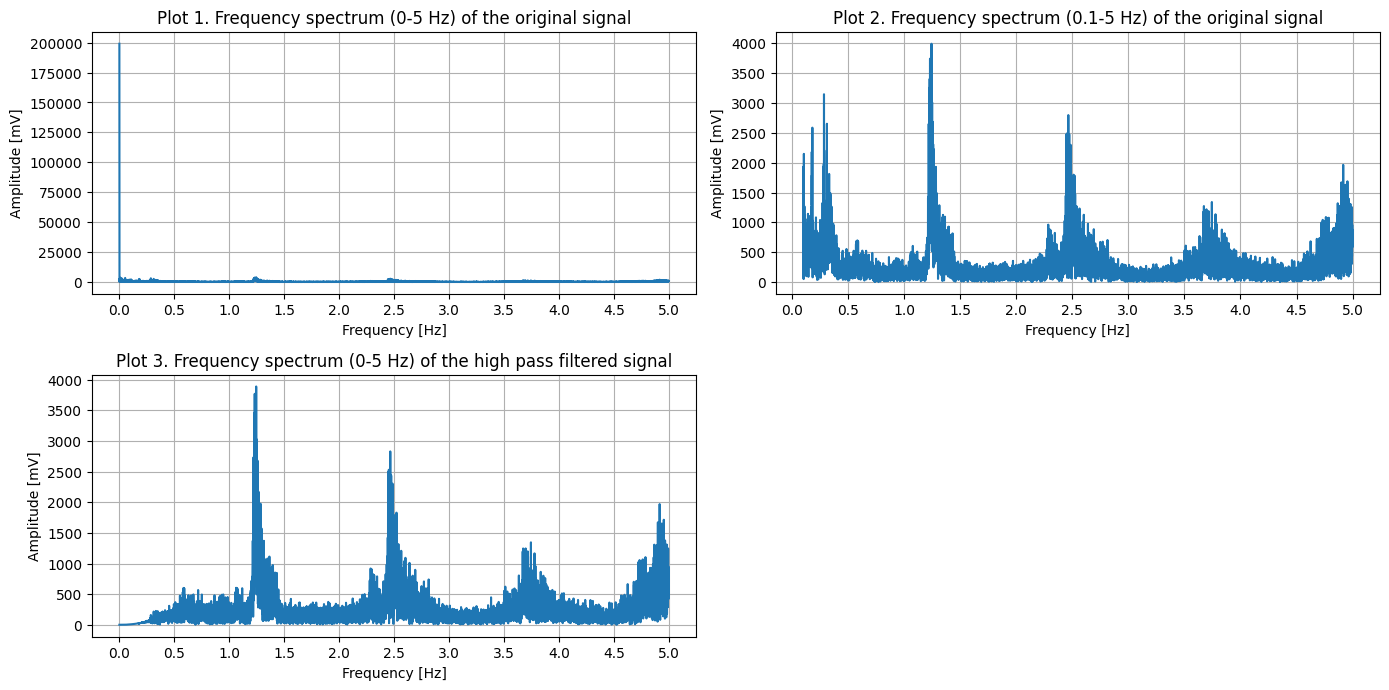

In [22]:
plt.figure(figsize=(14, 10))

# Displays the original signal's frequency spectrum between 0 and 5 Hz
filtered_frequencies, filtered_fft_data = get_frequency_spectrum(patient_record.p_signal[:,0], 0, 5)
plt.subplot(3, 2, 1)
plt.plot(filtered_frequencies, filtered_fft_data)
ax = plt.gca()  # Get the current axes
ax.xaxis.set_major_locator(ticker.MultipleLocator(0.5))
plt.title("Plot 1. Frequency spectrum (0-5 Hz) of the original signal")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Amplitude [mV]")
plt.grid(True)

# Displays the original signal's frequency spectrum between 0.1 and 5 Hz
filtered_frequencies, filtered_fft_data = get_frequency_spectrum(patient_record.p_signal[:,0], 0.1, 5)
plt.subplot(3, 2, 2)
plt.plot(filtered_frequencies, filtered_fft_data)
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(0.5))
plt.title("Plot 2. Frequency spectrum (0.1-5 Hz) of the original signal")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Amplitude [mV]")
plt.grid(True)

# Displays the high pass filtered signal's frequency spectrum between 0 and 5 Hz
filtered_frequencies, filtered_fft_data = get_frequency_spectrum(filtered_high_pass_signal, 0, 5)
plt.subplot(3, 2, 3)
plt.plot(filtered_frequencies, filtered_fft_data)
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(0.5))
plt.title("Plot 3. Frequency spectrum (0-5 Hz) of the high pass filtered signal")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Amplitude [mV]")
plt.grid(True)

plt.tight_layout()
plt.show()

It is possible to observe, in addition to the removal of the dominant DC bias in the first plot, the attenuation of low-frequency components between 0 Hz and 0.5 Hz, which are clearly visible in the second plot and significantly reduced in the third plot.

This confirms the filter's effectiveness in eliminating low-frequency artifacts, such as baseline drift, while preserving the relevant signal features.

Another potential source of noise in ECG recordings is power line interference, which typically manifests as a sinusoidal disturbance at 50 Hz or 60 Hz, depending on the electrical grid frequency of the region. This type of noise is caused by electromagnetic fluctuations from surrounding electrical devices and wiring.

Since it is unclear whether this type of interference is present in the dataset (and if so, in which frequency) it is necessary to perform spectral analysis to detect its presence. This can be achieved through the following steps:
- **Applying the Fast Fourier Transform (FFT):** this mathematical transformation converts the signal from the time domain, where it is represented as a function of time, to the frequency domain, where the individual frequency components of the signal can be analyzed
- **Identifying frequency peaks:** if significant peaks are observed at 50 Hz or 60 Hz, this suggests the presence of power line interference, and appropriate filtering techniques will be applied to remove it

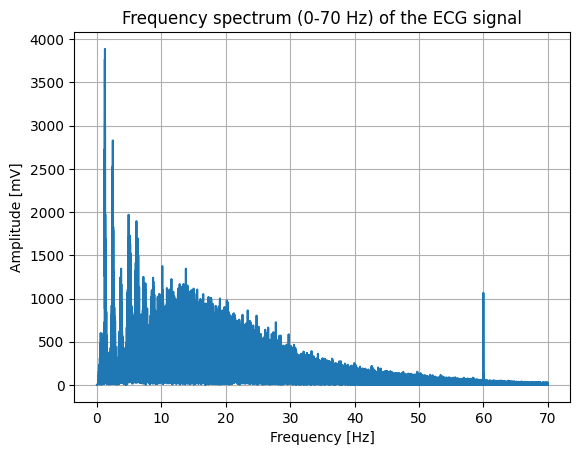

In [23]:
filtered_frequencies, filtered_fft_data = get_frequency_spectrum(filtered_high_pass_signal, 0, 70)

# Displays the frequency spectrum between 0 and 70 Hz
plt.plot(filtered_frequencies, filtered_fft_data)
plt.title("Frequency spectrum (0-70 Hz) of the ECG signal")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Amplitude [mV]")
plt.grid(True)
plt.show()

The plot clearly reveals an anomalous amplitude at 60 Hz, indicating the presence of powerline interference.

To selectively remove this affected frequency, a notch filter can be applied, after which the frequency spectrum is reexamined to confirm that the expected attenuation has occurred.

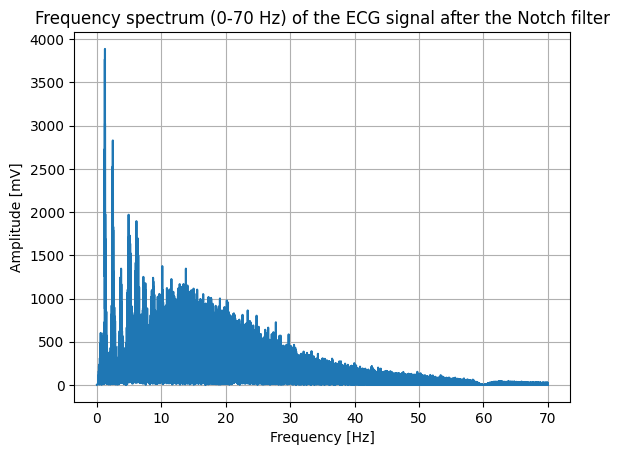

In [24]:
filtered_data_notch = notch_filter(filtered_high_pass_signal)
filtered_frequencies, filtered_fft_data = get_frequency_spectrum(filtered_data_notch, 0, 70)

# Displays the frequency spectrum between 0 and 70 Hz
plt.plot(filtered_frequencies, filtered_fft_data)
plt.title("Frequency spectrum (0-70 Hz) of the ECG signal after the Notch filter")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Amplitude [mV]")
plt.grid(True)
plt.show()

As anticipated, the frequencies around 60 Hz have been effectively eliminated.

Now we will analyze the signals before and after applying the filter to assess any observable changes.

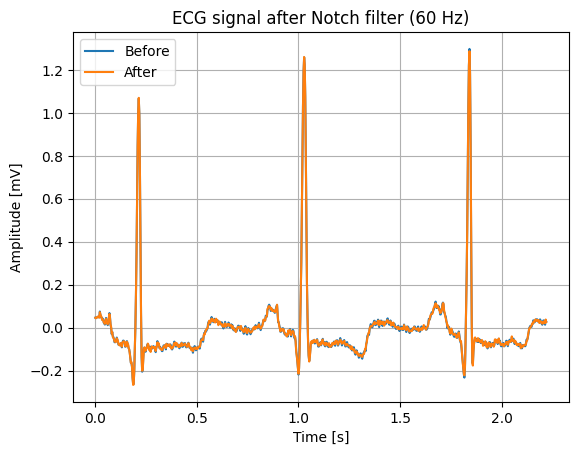

In [25]:
# Plot the new signal
t = np.arange(len(filtered_high_pass_signal[:800])) / 360  # Creating the time axis
plt.plot(t, filtered_high_pass_signal[:800])
plt.plot(t, filtered_data_notch[:800])
plt.title("ECG signal after Notch filter (60 Hz)")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude [mV]")
plt.grid(True)
plt.legend(("Before", "After"))
plt.show()

The new filtered signal is significantly smoother compared to the signal before applying the notch filter.

To conclude, a low-pass filter will be applied to remove frequencies above 150 Hz, as they do not contain relevant information for the ECG signal.

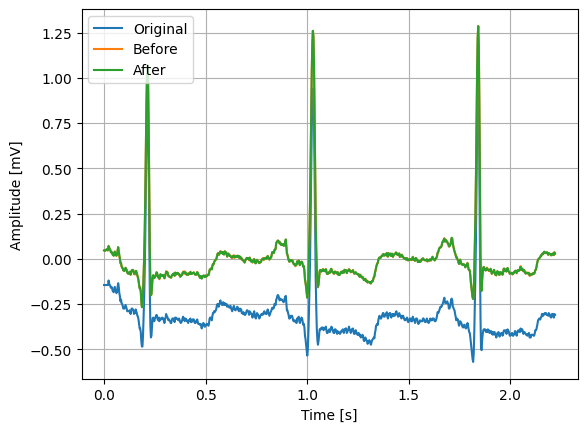

In [26]:
# Removing high frequencies > 150
t = np.arange(len(patient_record.p_signal[:,0][:800])) / 360  # Creating the time axis
filtered_signal_final = low_pass_filter(filtered_data_notch)
plt.plot(t, patient_record.p_signal[:,0][:800])
plt.plot(t, filtered_data_notch[:800])
plt.plot(t, filtered_signal_final[:800])
plt.xlabel("Time [s]")
plt.ylabel("Amplitude [mV]")
plt.grid(True)
plt.legend(("Original", "Before", "After"))
plt.show()

The signal exhibits minimal change compared to its previous state, likely due to the absence of significant high-frequency noise.

Nonetheless, this final filtering step is retained to illustrate an ideal workflow for the general denoising process of an ECG signal, even if its impact in this specific case is limited.

### **Segmentation stage**

Segmentation is the final stage of preprocessing and is closely related to both the structure of the database and the choice of the deep learning model, which in this case is an LSTM.

The MIT-BIH database provides annotations for each patient’s heartbeat. The goal is to segment the ECG signals so that each segment contains a single heartbeat, assigning it the corresponding label from the database.

A valid approach to obtaining segments that contain a single heartbeat is to identify the R peaks and isolate the regions to the left and right of each R peak based on a standardized distance.

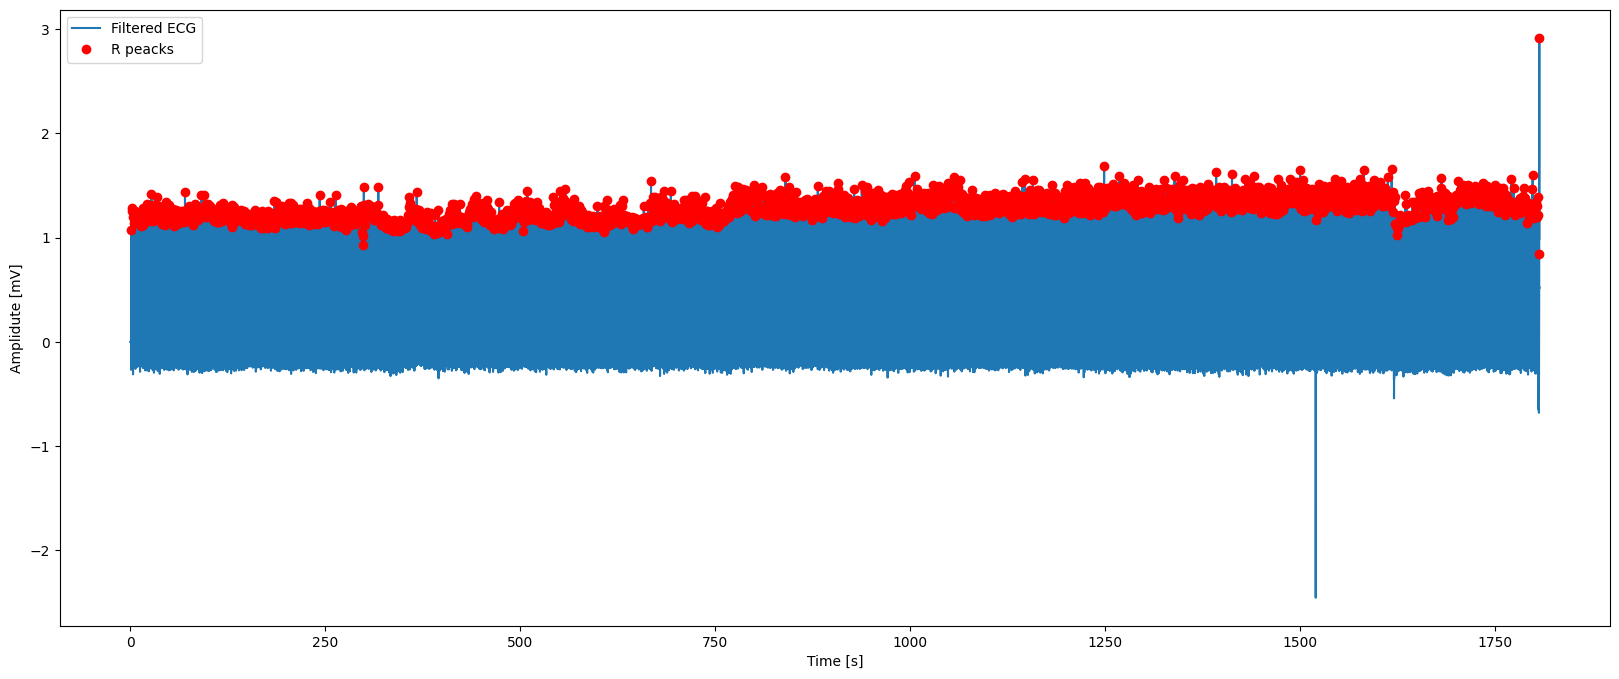

In [27]:
fs = 360  # Sampling rate (e.g. MIT-BIH)

# Add 1 second of padding on left
padding_length = fs
filtered_signal_final_padded = np.concatenate((np.zeros(padding_length), filtered_signal_final))

# Identifying peaks
peaks, _ = sp.signal.find_peaks(filtered_signal_final_padded, height=0.5, distance=fs//4)  # Minimum height and distance between peaks
# Another way to find R peaks is to use the NeuroKit library, but is more inaccurate than mine approach
## signals, info = nk.ecg_process(filteredSignalFinal, sampling_rate=360, method="engzeemod2012")
## peaks = info['ECG_R_Peaks']

# Plot
plt.figure(figsize=(20, 8))
t = np.arange(len(filtered_signal_final_padded)) / fs  # Creating the time axis
plt.plot(t, filtered_signal_final_padded, label="Filtered ECG")  # X-axis: time
plt.plot(t[peaks], filtered_signal_final_padded[peaks], "ro", label="R peacks")  # Use t[peaks] to align the x's
plt.xlabel("Time [s]")
plt.ylabel("Amplidute [mV]")
plt.legend()
plt.show()

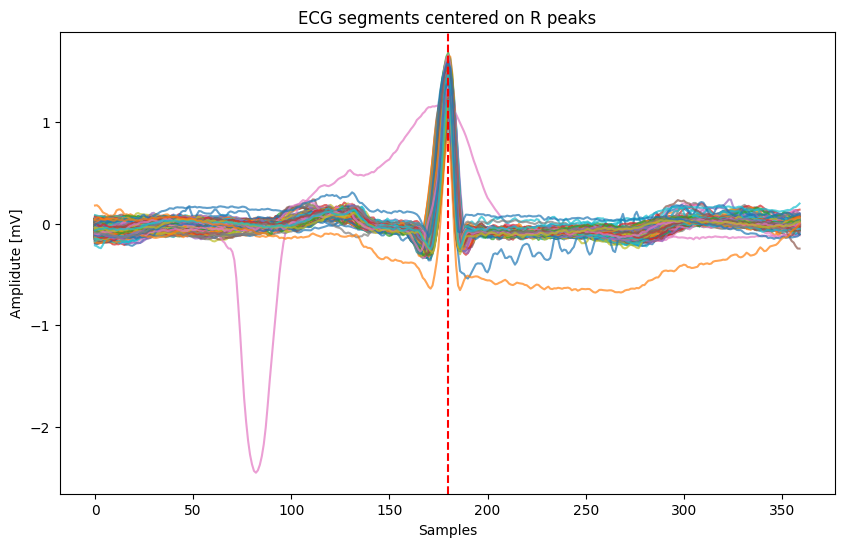

In [28]:
# define the length of the window around R
left = 180   # Samples on the left
right = 180  # Samples on the right

manual_segments = []
for r in peaks:
  if r - left >= 0 and r + right < len(filtered_signal_final_padded):  # Avoid edge problems
    segment = filtered_signal_final_padded[r - left : r + right]
    manual_segments.append(segment)

# Convert to array for easier plotting
manual_segments = np.array(manual_segments)

plt.figure(figsize=(10, 6))
for i, segment in enumerate(manual_segments):
  plt.plot(segment, alpha=0.7, label=f"Beat # {i+1}")

plt.axvline(left, color='r', linestyle='--', label="Centered R peak")  # Vertical line for R peak
plt.xlabel("Samples")
plt.ylabel("Amplidute [mV]")
plt.title("ECG segments centered on R peaks")
plt.show()

The plot appears to confirm the validity of the approach. It displays the heartbeats of patient #100, where the majority are classified as N.

The graph reveals a certain uniformity in the beats, with a few exceptions. This consistency makes it possible to clearly identify the primary labels associated with individual heartbeats.

As a final validation, I will verify whether the length of the manually extracted segments matches the length of the dataset annotations.

In [29]:
valid_symbols = [symbol for symbol in annotations.symbol if symbol != '+']
print(f"Are the two lengths equal? {len(manual_segments) == len(valid_symbols)}")
print(f"Manually extracted segments' length: {len(manual_segments)}\nAnnotation's length: {len(valid_symbols)}")

Are the two lengths equal? False
Manually extracted segments' length: 2272
Annotation's length: 2273


However, there is a discrepancy: the number of manually extracted segments does not correspond to the number of annotated segments in the dataset. Moreover, several annotations do not classify the type of heartbeat (e.g., "+", "~", or "/") and should therefore be excluded from the analysis.

I need to change strategy.

I will select the segments directly from the MIT-BIH dataset, discarding all annotations that do not label the heartbeat type. Although this approach will result in the loss of some input signals for the model, it will ensure that the labels are correctly assigned and that the segments are significant for the prediction of the heartbeat type.

In [30]:
valid_beat_symbols = {"N", "L", "R", "A", "a", "J", "S", "V", "F","!", "e", "j", "E", "f", "x", "Q"}
valid_indices = [i for i, s in enumerate(annotations.symbol) if s in valid_beat_symbols]
filtered_samples = annotations.sample[valid_indices]
filtered_symbols = np.array(annotations.symbol)[valid_indices]

window_size = 200  # 100 on left, 100 on right
segments = []
labels = []

for r_peak, label in zip(filtered_samples, filtered_symbols):
  start = max(0, r_peak - window_size // 2)
  end = min(len(filtered_signal_final), r_peak + window_size // 2)
  segment = filtered_signal_final[start:end]

  # If the segment does not have the correct length, we discard it
  if len(segment) == window_size:
    segments.append(segment)
    labels.append(label)


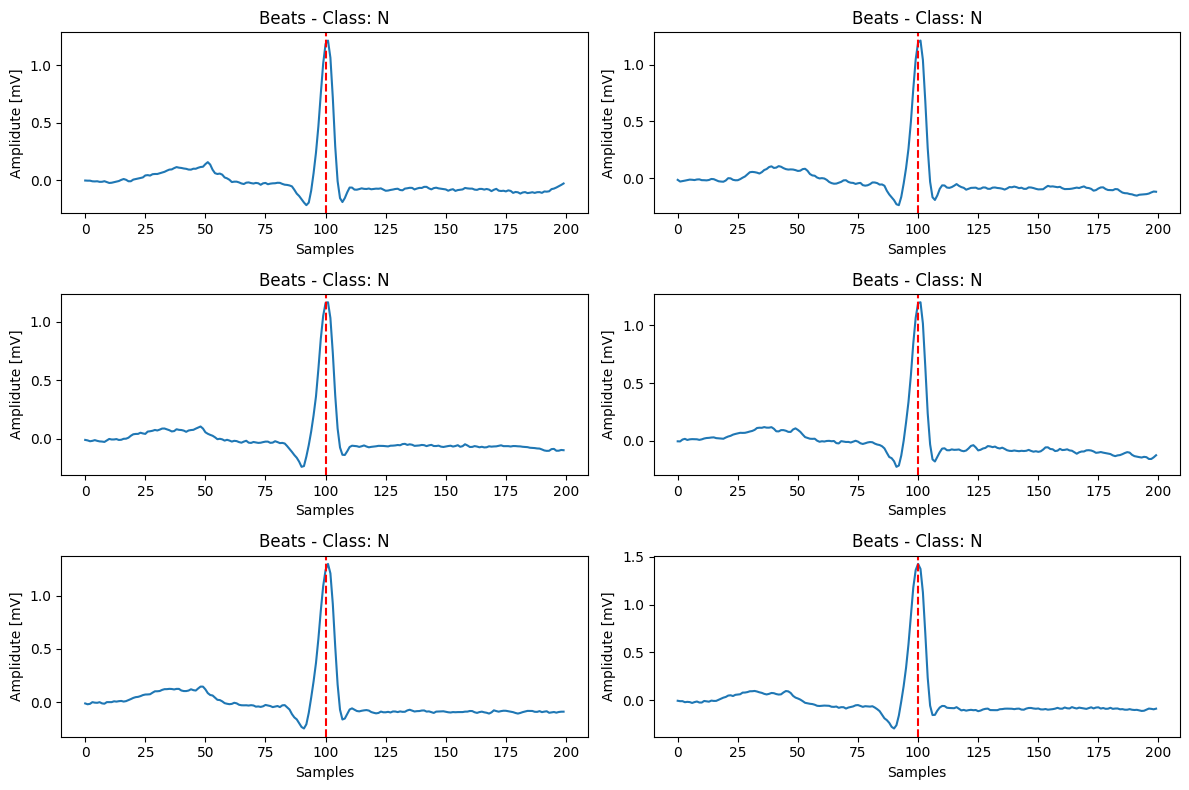

In [31]:
# Randomly choose some segments to plot
num_plots = 6
random_indices = random.sample(range(len(segments)), num_plots)

plt.figure(figsize=(12, 8))
for i, idx in enumerate(random_indices, 1):
  plt.subplot(3, 2, i)
  plt.plot(segments[idx])
  plt.axvline(x=window_size // 2, color='r', linestyle='--')  # Indicates the center (peak R)
  plt.title(f"Beats - Class: {labels[idx]}")
  plt.xlabel("Samples")
  plt.ylabel("Amplidute [mV]")
plt.tight_layout()
plt.show()

In the MIT-BIH dataset, the annotations made by doctors are generally positioned around the R peak or within the QRS complex.

Therefore, when plotting all segments, the R peak is expected to appear near the center.

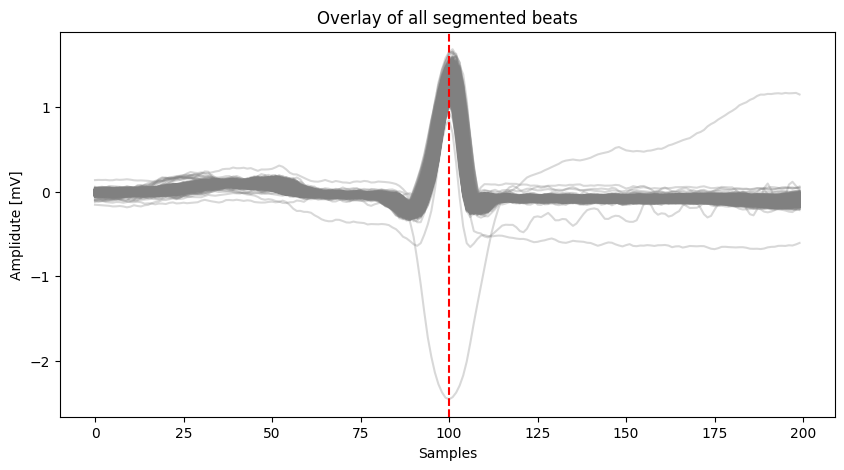

In [32]:
plt.figure(figsize=(10, 5))
for segment in segments:
  plt.plot(segment, color="gray", alpha=0.3)  # Transparency for overlay
plt.axvline(x=window_size // 2, color='r', linestyle='--')  # Center
plt.title("Overlay of all segmented beats")
plt.xlabel("Samples")
plt.ylabel("Amplidute [mV]")
plt.show()

As anticipated, the plot confirms this pattern. Centering the R peak around the 100th sample could aid the model in determining whether a heartbeat exhibits signs of arrhythmia.

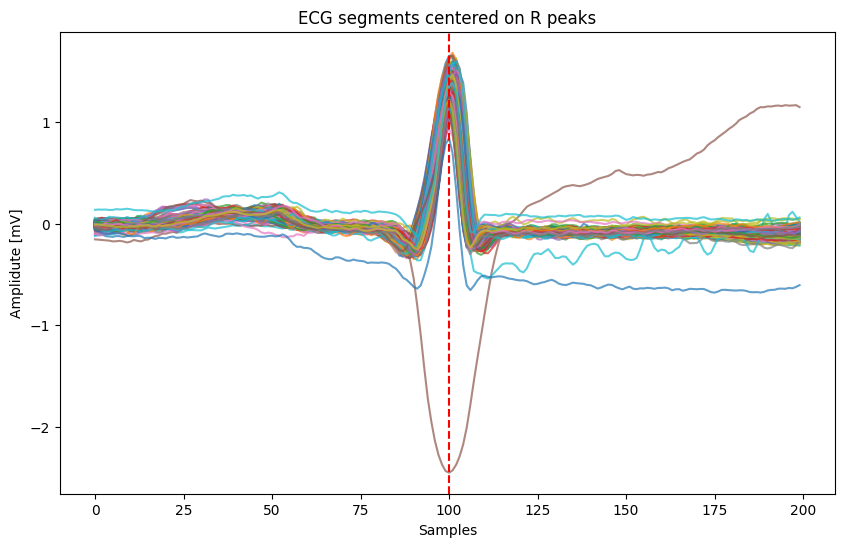

In [33]:
plt.figure(figsize=(10, 6))
for i, segment in enumerate(segments):
  plt.plot(segment, alpha=0.7, label=f"Beat # {i+1}")

plt.axvline(x=window_size // 2, color='r', linestyle='--')  # Center
plt.xlabel("Samples")
plt.ylabel("Amplidute [mV]")
plt.title("ECG segments centered on R peaks")
plt.show()

In [34]:
print(f"Manually extracted segments' length (older version): {len(manual_segments)}")
print(f"Valid symbols' length: {len(filtered_symbols)}")
print(f"New valid symbols' length: {len(labels)}")
print(f"New segments' length: {len(segments)}")
print(f"Are the new segments' lengths equal to the labels' lengths? {len(segments) == len(labels)}")

Manually extracted segments' length (older version): 2272
Valid symbols' length: 2273
New valid symbols' length: 2271
New segments' length: 2271
Are the new segments' lengths equal to the labels' lengths? True


This approach appears more promising. Although the number of segments is significantly lower than in the previous method (due either to the presence of labels that do not correspond to a valid beat type or to segments that do not match the required fixed length), we can be confident that these segments are clinically relevant for our purposes.

Now, we will proceed with preprocessing all available signals in the dataset.

In [35]:
def filter_beat_annotations(annotations, valid_beat_symbols):
  """
  Filters the beat annotations to retain only those that correspond to valid beat types.

  Parameters:
  - annotations: a wtdb Annotation object that contains the annotations
  - valid_beat_symbols: a set of valid beat symbols
    Only the annotations whose symbols appear in this list will be retained

  Returns:
  - filtered_symbols: a NumPy array containing the valid beat labels (symbols) that passed the filter.
  - filtered_samples: a NumPy array containing the sample positions corresponding to the valid beats.
  """
  # Filter annotations to keep only valid beats
  valid_indices = [i for i, s in enumerate(annotations.symbol) if s in valid_beat_symbols]
  filtered_samples = annotations.sample[valid_indices]  # Beat positions
  filtered_symbols = np.array(annotations.symbol)[valid_indices]  # Beat labels
  return filtered_symbols, filtered_samples

In [36]:
def signal_filtering(raw_signal):
  """
  Applies a series of filters (high-pass, notch, and low-pass) to a raw ECG signal.

  Parameters:
  - raw_signal: a NumPy array representing the raw ECG signal to be filtered

  Returns:
  - A NumPy array containing the filtered ECG signal after applying all three filters.
  """
  # High-pass filter
  filteredHighPassSignal = high_pass_filter(raw_signal)
  # Notch filter
  filteredNotchSignal = notch_filter(filteredHighPassSignal)
  # Low-pass filter
  return low_pass_filter(filteredNotchSignal)

In [37]:
def simplify_label(label):
  match label:
      case "N" | "L" | "R" | "j" | "e":
          return "N"
      case "A" | "a" | "S" | "J":
          return "S"
      case "V" | "E":
          return "V"
      case "F":
          return "F"
      case _:
          return "U"

def segmentation_process(signal, filtered_samples, filtered_symbols):
  """
  Segments the ECG signal into fixed-length windows around R-peaks and assigns corresponding labels.

  Parameters:
  - signal: a NumPy array representing the ECG signal to be segmented
  - filtered_samples: a NumPy array containing the sample positions (indices) of the R-peaks in the ECG signal
  - filtered_symbols: a NumPy array containing the corresponding beat labels for each R-peak

  Returns:
  - segments: a list of NumPy arrays, each containing a segment of the ECG signal centered around an R-peak
  - labels: a list of simplified labels corresponding to the segments
  """
  window_size = 200  # 100 on left, 100 on right
  segments = []
  labels = []

  for r_peak, raw_label in zip(filtered_samples, filtered_symbols):
    label = simplify_label(raw_label)
    start = max(0, r_peak - window_size // 2)
    end = min(len(signal), r_peak + window_size // 2)
    segment = signal[start:end]

    # If the segment does not have the correct length, we discard it
    if len(segment) == window_size:
      segments.append(segment)
      labels.append(label)

  return segments, labels # There are list!

In [38]:
def normalization_process(raw_segments, scaler):
  """
  Normalizes each segment of the raw ECG signal using a specified scaler.

  Parameters:
  - raw_segments: a list of NumPy arrays, where each array represents a raw ECG segment
  - scaler: A scaler object (sklearn.preprocessing.MinMaxScaler) used to normalize each segment

  Returns:
  - normalized_beats: s list of NumPy arrays containing the normalized ECG segments
  """
  normalized_beats = []
  for raw_segment in raw_segments:
    # Describe what's happened here
    normalized_segment = scaler.fit_transform(np.array(raw_segment).reshape(-1, 1)).reshape(-1)
    normalized_beats.append(normalized_segment)

  return normalized_beats

I proceed by collecting all available data from the dataset. For each patient, I retrieve the following information: the two raw ECG leads and the filtered segment labels, which include only the annotations related to the type of heartbeat.

The ECG signals are then filtered, segmented into fixed-size windows, and normalized to the range (0, 1). This normalization is necessary because, in the subsequent model, the softmax activation function will be used, and it is more numerically stable to keep the values within the softmax range.

Finally, a list of dictionaries is generated, where each dictionary represents a patient and contains the relevant retrieved and processed data.

In [39]:
if COLAB:
  drive.mount('/content/gdrive')
  path = "/content/gdrive/MyDrive/mit-bih-arrhythmia-database-1.0.0"
else:
  path = "mit-bih-arrhythmia-database-1.0.0"

valid_beat_symbols = {"N", "L", "R", "A", "a", "J", "S", "V", "F","!", "e", "j", "E", "f", "x", "Q"}
patients_data = []
scaler = MinMaxScaler(feature_range=(0, 1))

print(f"Start loading...")
for patient_id in tqdm(range(100, 235), initial=1, total=135):  # From patient 100 to patient 234
  try:
    patient_record = wfdb.rdrecord(f"{path}/{patient_id}")
    annotations = wfdb.rdann(f"{path}/{patient_id}", 'atr')

    filtered_symbols, filtered_samples = filter_beat_annotations(annotations, valid_beat_symbols)
    first_lead_cleaned_signal = signal_filtering(patient_record.p_signal[:, 0]) # First lead (numpy array)
    second_lead_cleaned_signal = signal_filtering(patient_record.p_signal[:, 1]) # Second lead (numpy array)

    first_lead_raw_segments, first_lead_labels = segmentation_process(first_lead_cleaned_signal, filtered_samples, filtered_symbols)
    second_lead_raw_segments, second_lead_labels = segmentation_process(second_lead_cleaned_signal, filtered_samples, filtered_symbols)
    first_lead_segments = normalization_process(first_lead_raw_segments, scaler)
    second_lead_segments = normalization_process(second_lead_raw_segments, scaler)

    segments = first_lead_segments + second_lead_segments
    labels = first_lead_labels + second_lead_labels

    # Save everything in a dictionary
    patient_entry = {
      "patient_id": patient_id,
      "ecg_first_lead": first_lead_cleaned_signal,
      "ecg_second_lead": second_lead_cleaned_signal,
      "fs": patient_record.fs,
      "lead_names": patient_record.sig_name,
      "beats": segments,
      "beat_labels": labels,
    }
    patients_data.append(patient_entry)

  except FileNotFoundError: # Catch error if the patient's number does not exist
    #print(f"Patient {patient_id} not found, moving next...")
    pass

print(f"Loaded compleated!")

Start loading...


136it [00:47,  2.85it/s]                         

Loaded compleated!


Let's try to visualize a single normalized ECG segment and then overlay all the normalized segments. In both plots, the results are exactly as expected: the segments are confined to a range between 0 and 1.

Notably, when all segments are superimposed, two distinct groups emerge, with a clear separation between them. This likely corresponds to the two ECG leads in the dataset. Since each lead records the heartbeat from a different spatial perspective, the leads exhibit different potential differences, resulting in the observed separation in the overlay plot.

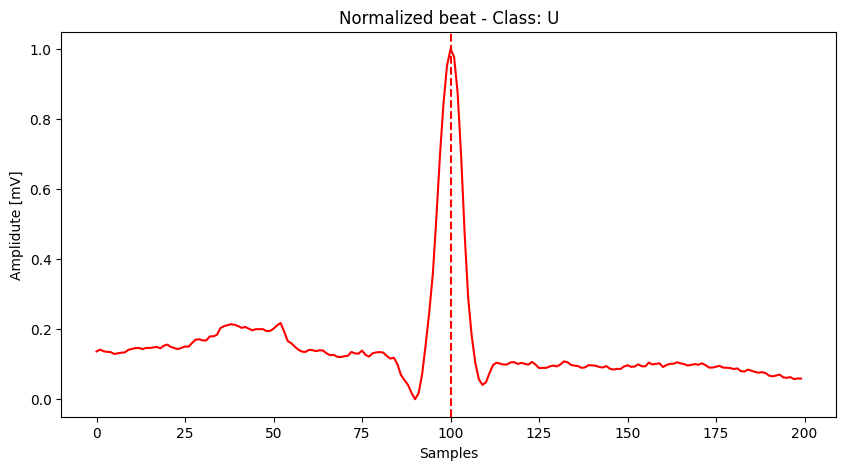

In [40]:
plt.figure(figsize=(10, 5))
segment = patients_data[0].get('beats')[0]
plt.plot(segment, color="r")  # Transparency for overlay
plt.axvline(x=window_size // 2, color='r', linestyle='--')  # Center
plt.title(f"Normalized beat - Class: {patients_data[4].get('beat_labels')[0]}")
plt.xlabel("Samples")
plt.ylabel("Amplidute [mV]")
plt.show()

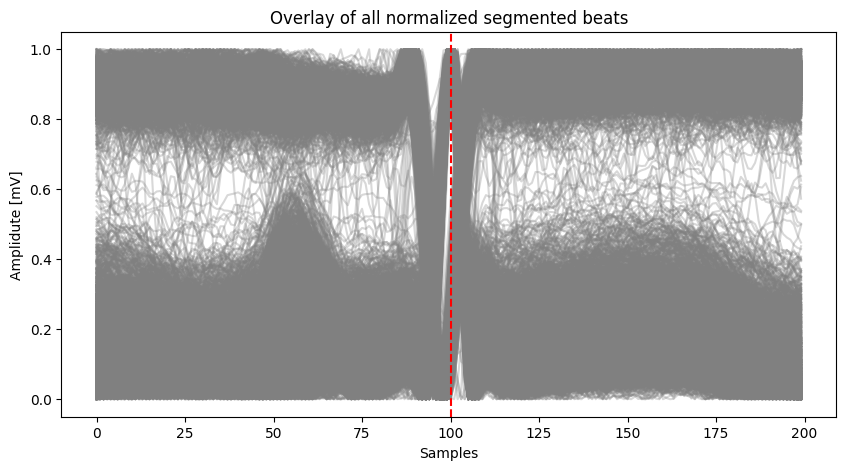

In [41]:
plt.figure(figsize=(10, 5))
for segment in patients_data[40].get('beats'):
  plt.plot(segment, color="gray", alpha=0.3)  # Transparency for overlay
plt.axvline(x=window_size // 2, color='r', linestyle='--')  # Center
plt.title("Overlay of all normalized segmented beats")
plt.xlabel("Samples")
plt.ylabel("Amplidute [mV]")
plt.show()

Mean: 0.4411, Standard deviation: 0.3085
Min: 0.0000, Max: 1.0000


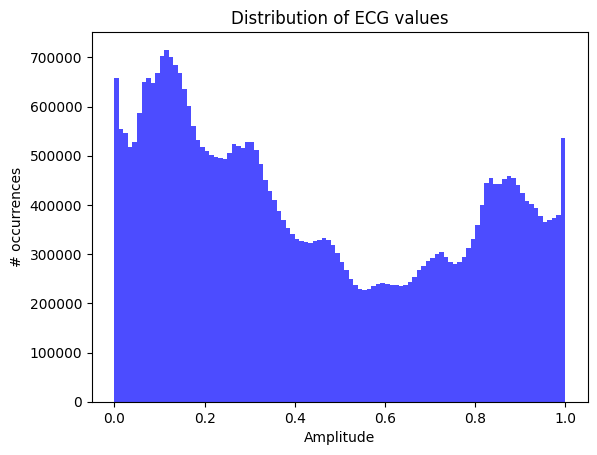

In [42]:
# Initialize the list to collect all segments
all_segments = []
all_labels = []

for patient in patients_data:
  for segment, label in zip(patient.get('beats'), patient.get('beat_labels')):
    # Add the segment as numpy array
    all_segments.append(np.array(segment))
    all_labels.append(np.array(label))

all_segments_values = np.concatenate(all_segments)
all_labels = np.array(all_labels)

# Get mean, standard deviation, min and max
mean_val = np.mean(all_segments_values)
std_val = np.std(all_segments_values)
min_val, max_val = np.min(all_segments_values), np.max(all_segments_values)
print(f"Mean: {mean_val:.4f}, Standard deviation: {std_val:.4f}")
print(f"Min: {min_val:.4f}, Max: {max_val:.4f}")

# Distribution histogram
plt.hist(all_segments_values, bins=100, alpha=0.7, color="blue")
plt.title("Distribution of ECG values")
plt.xlabel("Amplitude")
plt.ylabel("# occurrences")
plt.show()

In [43]:
# Function to apply time shift
def time_shift(signal, shift=5):
  """
  Applies a time shift to the input signal by a specified number of samples.

  Parameters:
  - signal (numpy.ndarray): the input signal
  - shift (int, optional): the number of samples to shift the signal.
                           Positive values shift forward, negative values shift backward. (Default 5)
  Returns:
  - output (numpy.ndarray): the time-shifted signal.
  """
  output = np.roll(signal, shift)
  return output

# Function to change the amplitude
def amplitude_scaling(signal, scale_range=(0.9, 1.1)):
  """
  Scales the amplitude of the input signal by a randomly selected factor within a specified range.

  Parameters:
  - signal (numpy.ndarray): the input signal
  - scale_range (tuple of float, optional): The range (min, max) from which the scaling factor is sampled.
                                            (Default (0.9, 1.1))

  Returns:
  - output (numpy.ndarray): the amplitude-scaled signal.
  """
  scale = np.random.uniform(*scale_range) # check the *
  output = signal * scale
  return output

In [44]:
def rebalance_classes_N_and_F(all_segments, all_labels):
  """
  Rebalances the dataset by applying downsampling to class 'N' and data augmentation to class 'F'.

  Parameters:
  - all_segments (list of numpy.ndarray): The list of signal arrays to be balanced
  - all_labels (numpy.ndarray): The array of labels corresponding to the signals

  Returns:
  - balanced_segments (list of numpy.ndarray): The rebalanced list of signal arrays
  - balanced_labels (numpy.ndarray): The rebalanced array of labels
  """
  ### Downsampling class N -> from 90603 to 8000 segments
  target_N = 20000
  # Find the indexes of class "N"
  indices_N = [i for i, label in enumerate(all_labels) if label == 'N']
  # Randomly select 20000 indexes from the available ones
  selected_N_indices = np.random.choice(indices_N, target_N, replace=False)
  # Find the indices of all other classes
  other_indices = [i for i, label in enumerate(all_labels) if label != 'N']
  # Combine the indexes while maintaining the balance in the new list
  final_indices = list(selected_N_indices) + other_indices
  # Reorder labels as in the original
  final_indices.sort()
  # Create new balanced lists
  balanced_segments = [all_segments[i] for i in final_indices]
  balanced_labels = [all_labels[i] for i in final_indices]

  ### Data augmentation class F -> from 802 to 1604
  ## Time Shift (401 new signals) + Amplitude Scaling (401 new signals)
  # Find the indexes of class "F"
  indices_F = [i for i, label in enumerate(balanced_labels) if label == 'F']
  # List for new segments and labels
  augmented_segments = []
  augmented_labels = []

  selected_indices = np.random.choice(indices_F, size=401, replace=False)  # Select 401 random indices
  for i in selected_indices:
    shift_value = np.random.randint(-5, 6)  # Random shift between -5 e +5
    augmented_segment = np.array(time_shift(balanced_segments[i], shift=shift_value))
    augmented_segments.append(augmented_segment)
    augmented_labels.append('F')

  selected_indices = np.random.choice(indices_F, size=401, replace=False)  # Select 401 random indices
  for i in selected_indices:
    scaler = MinMaxScaler(feature_range=(0, 1))
    augmented_segment = scaler.fit_transform(np.array(amplitude_scaling(balanced_segments[i])).reshape(-1, 1)).reshape(-1) # Normalized amplitude scaling (multiply the signal by a range (0.9, 1.1))
    augmented_segments.append(augmented_segment)
    augmented_labels.append('F')

  # Add the augmented data to the dataset
  balanced_segments.extend(augmented_segments)
  balanced_labels.extend(augmented_labels)

  return balanced_segments, balanced_labels


Before creating the dataloader, it is essential to verify whether the dataset classes are balanced. Several preprocessing steps have already been applied, modifying the original dataset. Therefore, this verification is mandatory.

To ensure class distribution is appropriate, we will count the number of examples for each label:

In [45]:
# Count the occurrences of each label
print(f"Length before downsampling on label N and data augmentation on label F:")
unique_labels, counts = np.unique(all_labels, return_counts=True)
tot = 0
# Print the results
for label, count in zip(unique_labels, counts):
  print(f"Label {label}: {count}")
  tot += count
print(f"Total count: {tot}\n")

Length before downsampling on label N and data augmentation on label F:
Label F: 1604
Label N: 181206
Label S: 5562
Label U: 3360
Label V: 14470
Total count: 206202



We can clearly observe that the dataset is highly imbalanced:
* The N type beats are about 180000
* The F type beats are only about 1600

This imbalance poses a challenge for training a deep learning model, as it may learn to classify N beats as the majority class while disregarding F beats as statistically insignificant.

Therefore, it is necessary to modify the dataset to mitigate this issue. To address this:
* First, we reduce the number of N-labeled segments to 20000. This ensures that they remain the majority class, as they represent normal beats, but prevents the model from converging too strongly towards the N class.
* Second, to balance the F segments, we apply two types of data augmentation:
    * Random time shifting: We generate 401 new segments by shifting 401 randomly selected signals by a random value between -5 and +5 samples. This shift value is also randomly generated
    * Amplitude variation: We create 401 additional segments by modifying the amplitude of 401 randomly chosen signals by a randomly selected factor between 0.9 and 1.1

In [46]:
print(f"Length after downsampling on label N and data augmentation on label F:")
new_all_segments, new_all_labels = rebalance_classes_N_and_F(all_segments, all_labels)
unique_labels, counts = np.unique(new_all_labels, return_counts=True)
tot = 0
# Print the results
for label, count in zip(unique_labels, counts):
  print(f"Label {label}: {count}")
  tot += count
print(f"Total count: {tot}")

Length after downsampling on label N and data augmentation on label F:
Label F: 2406
Label N: 20000
Label S: 5562
Label U: 3360
Label V: 14470
Total count: 45798


With these operations, the dataset size was reduced from 206202 segments to 45798, resulting in fewer segments but a more balanced distribution.

In [47]:
count_true = 0
count_false = 0
for segment in new_all_segments:
  if segment.ndim == 1:
    count_true += 1
  else:
    print(f"dim: {segment.ndim}")
    count_false += 1

print(f"Count_true : {count_true}")
print(f"Count_false : {count_false}")

Count_true : 45798
Count_false : 0


In [48]:
print(f"Segments {type(new_all_segments)}, len: {len(new_all_segments)}")
print(f"Segment {type(new_all_segments[0])}, len: {len(new_all_segments[0])}")
print(f"Labels {type(new_all_labels)}, len: {len(new_all_labels)}")

Segments <class 'list'>, len: 45798
Segment <class 'numpy.ndarray'>, len: 200
Labels <class 'list'>, len: 45798


In [49]:
# Check the lengths of sublists or arrays
lengths = [len(segment) for segment in new_all_segments]
check = True
for length in lengths:
    if length != 200:
        check = False
        break

print(f"Does all segments have 200 length? {check}")

Does all segments have 200 length? True


In [50]:
numpy_segments = np.array(new_all_segments)
print(f"numpy_segments' shape: {numpy_segments.shape}")
numpy_segments = np.expand_dims(numpy_segments, axis=-1) # review this line
print(f"new numpy_segments' shape: {numpy_segments.shape}")

numpy_labels = np.array(new_all_labels)
print(f"all_labels' shape: {numpy_labels.shape}")

numpy_segments' shape: (45798, 200)
new numpy_segments' shape: (45798, 200, 1)
all_labels' shape: (45798,)


Now, we proceed with creating the dataset.

The `torch.utils.data` module provides classes to load and manipulate datasets.

The `Dataset` class is the base class for all datasets. We can define our own dataset by subclassing `Dataset` and defining the `__len__` and `__getitem__` methods:
* the `__len__` method should return the size of the dataset
* the `__getitem__` method should return the $i$-th sample of the dataset

The `DataLoader` class is used to load the dataset and provide batches of samples. It takes as input a dataset and the batch size.

In [51]:
class ECGDataset(Dataset):
  def __init__(self, X, y): # transform=None (take into account later)
    """
    X: NumPy array of shape (n_samples, n_timesteps, n_features)
    y: NumPy array of shape (n_samples,)
    transform: Transformation function to apply to data
    """

    assert len(X) == len(y), "X and y must have the same lengths"
    assert len(X) > 0, "X cannot be empty"
    assert len(y) > 0, "y cannot be empty"
    self.X = torch.tensor(X, dtype=torch.float32)
    self.y = torch.tensor(y, dtype=torch.long)
    #self.transform = transform

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    segment = self.X[idx]
    label = self.y[idx]

    """if self.transform:
        segment = self.transform(segment)"""

    return segment, label

Although several balancing operations have been applied to the dataset, the number of samples per class remains unequal.

To ensure effective model training, we implement a Weighted Random Sampler for the training set. This technique allows the model to be exposed to all classes more equitably, mitigating the risk of overfitting to the majority class. The sampler assigns an inverse frequency weight to each class, increasing the likelihood of selecting samples from underrepresented classes.

After implementing the sampler, the dataset is partitioned into training, validation, and test sets with proportions of 70%, 15%, and 15%, respectively.

Finally, we construct DataLoaders for each subset. The training DataLoader incorporates the weighted sampler to address class imbalance, while the validation and test DataLoaders utilize shuffling to enhance generalization.

In [52]:
# Convert string labels to numerical indices
label_encoder = LabelEncoder()
all_labels_numeric = label_encoder.fit_transform(numpy_labels) # all_labels_numeric is a NumPy array

# Create the dataset and the DataLoader
dataset = ECGDataset(numpy_segments, all_labels_numeric)
batch_size = 128
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create a sampler only for the training set
train_labels = [train_dataset.dataset.y[i] for i in train_dataset.indices] # This is a list!
train_labels = torch.tensor(train_labels, dtype=torch.long)
class_counts = torch.bincount(train_labels)
class_weights = 1. / class_counts
sample_weights = class_weights[train_labels]
sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
# Create a DataLoader for validation (without sampler)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

### **Feature extraction stage**

For the model I intend to implement later, I plan to pass the ECG signals directly to the model, preserving the amplitude values over time.

This approach is known as end-to-end learning. Given this implementation choice, I will not explore various feature extraction techniques in detail.

### **Classification stage**

Since this study involves time series data, I have chosen to implement a simple Long Short-Term Memory (LSTM) network, as it generally outperforms a standard Recurrent Neural Network (RNN). If the results are satisfactory, exploring a Transformer-based model could be a viable next step.

The proposed model consists of:
* Four bidirectional LSTM layers, each with 128 hidden units
* Batch normalization applied between each layer
* A final fully connected layer for probabilistic classification
* A dropout layer between the last LSTM layer and the fully connected layer to mitigate overfitting

In [53]:
# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [54]:
class LSTMModel(nn.Module):
  """
  A deep bidirectional LSTM model for sequence classification.
  This model consists of four bidirectional LSTM layers, each followed by batch normalization.
  A final fully connected layer performs probabilistic classification.

  Constructor method
    Parameters:
    - input_size (int): number of input features per time step
    - hidden_size1 (int): number of hidden units in each LSTM layer
    - num_classes (int): number of output classes
    - dropout_rate (float, optional): dropout probability applied before the final fully connected layer.
                                      (Default is 0.1)

  Forward method
    Parameter:
    - x (torch.Tensor): input tensor of shape (batch_size, sequence_length, input_size)

    Returns:
    - torch.Tensor: output tensor of shape (batch_size, num_classes), containing class logits before
                    applying softmax
  """
  def __init__(self, input_size, hidden_size1, num_classes, dropout_rate=0.1):
    super().__init__()

    # LSTM Layer 1
    self.lstm1 = nn.LSTM(input_size, hidden_size1, batch_first=True, bidirectional=True)
    self.batch_norm1 = nn.BatchNorm1d(2*hidden_size1)

    # LSTM Layer 2
    self.lstm2 = nn.LSTM(2*hidden_size1, hidden_size1, batch_first=True, bidirectional=True)
    self.batch_norm2 = nn.BatchNorm1d(2*hidden_size1)

    # LSTM Layer 3
    self.lstm3 = nn.LSTM(2*hidden_size1, hidden_size1, batch_first=True, bidirectional=True)
    self.batch_norm3 = nn.BatchNorm1d(2*hidden_size1)

    # LSTM Layer 4
    self.lstm4 = nn.LSTM(2*hidden_size1, hidden_size1, batch_first=True, bidirectional=True)
    self.batch_norm4 = nn.BatchNorm1d(2*hidden_size1)

    # Fully Connected Layer
    self.dropout = nn.Dropout(dropout_rate)
    self.fc = nn.Linear(2*hidden_size1, num_classes)

  def forward(self, x):
    # LSTM Layer 1
    x, _ = self.lstm1(x)  # Output shape: (batch_size, 200, hidden_size1)
    x = self.batch_norm1(x.permute(0, 2, 1)).permute(0, 2, 1)

    # LSTM Layer 2
    x, _ = self.lstm2(x)  # Output shape: (batch_size, 200, hidden_size1)
    x = self.batch_norm2(x.permute(0, 2, 1)).permute(0, 2, 1)

    # LSTM Layer 3
    x, _ = self.lstm3(x)  # Output shape: (batch_size, 200, hidden_size1)
    x = self.batch_norm3(x.permute(0, 2, 1)).permute(0, 2, 1)

    # LSTM Layer 4
    x, _ = self.lstm4(x)  # Output shape: (batch_size, 200, hidden_size1)
    x = self.batch_norm4(x.permute(0, 2, 1))#.permute(0, 2, 1)

    # Take the final time step output
    x = x[..., -1]  # Output shape: (batch_size, hidden_size1)

    # Fully Connected Layer
    x = self.dropout(x)
    x = self.fc(x)  # Output shape: (batch_size, num_classes)

    return x

# Define model parameters
input_size = 1  # Number of features
hidden_size1 = 160  # Number of hidden units in LSTM Layer 1
num_classes = 5     # Number of classes (F, N, S, U, V)
dropout_rate = 0.1  # Dropout rate

# Initialize the model
model = LSTMModel(input_size, hidden_size1, num_classes, dropout_rate).to(device)

# Print the model architecture
print(model)

LSTMModel(
  (lstm1): LSTM(1, 160, batch_first=True, bidirectional=True)
  (batch_norm1): BatchNorm1d(320, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lstm2): LSTM(320, 160, batch_first=True, bidirectional=True)
  (batch_norm2): BatchNorm1d(320, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lstm3): LSTM(320, 160, batch_first=True, bidirectional=True)
  (batch_norm3): BatchNorm1d(320, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lstm4): LSTM(320, 160, batch_first=True, bidirectional=True)
  (batch_norm4): BatchNorm1d(320, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc): Linear(in_features=320, out_features=5, bias=True)
)


For the loss function, I will use cross-entropy, which inherently incorporates the softmax activation function for multi-class classification.

As for the optimizer, I will employ AdamW, which represents the current state of the art. 

Initially, I used a simple linear scheduler to gradually reduce the learning rate during training. However, after several training cycles, I recognized the need for a more tailored scheduler for this task. Consequently, I opted for [ReduceLROnPlateau](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ReduceLROnPlateau.html), which dynamically adjusts the learning rate based on specific conditions, leading to improvements in model performance.

In [55]:
# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.AdamW(model.parameters(), weight_decay=0, lr=0.0001)
num_epochs = 50
#scheduler = LinearLR(optimizer, start_factor=1, end_factor=0.1, total_iters=num_epochs)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, cooldown=2, min_lr=1e-10)

For the training loop, I set the number of epochs to 50 and implemented early stopping with a patience criterion. Specifically, if the validation loss does not improve for 10 consecutive epochs, training is terminated, and the model with the lowest validation loss is saved.

In [58]:
# Define early stopping parameters
patience = 10  # Number of epochs to wait before stopping
best_val_loss = np.inf  # Initialize best validation loss to infinity
trigger_times = 0  # Counter for epochs without improvement

training_loss = []
validation_loss = []
accuracy_train = []
accuracy_val = []

torchmetric_accuracy = Accuracy(task="multiclass", num_classes=5).to(device)

# Training loop with early stopping
for epoch in range(num_epochs):
  model.train()
  running_loss = 0.0
  running_acc = 0.0
  for batch_segments, batch_labels in train_loader:
    # Move data to device
    batch_segments = batch_segments.to(device)
    batch_labels = batch_labels.to(device)

    # Forward pass
    outputs = model(batch_segments)
    loss = criterion(outputs, batch_labels)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
    running_acc += torchmetric_accuracy(torch.softmax(outputs, dim=1).argmax(dim=1), batch_labels)

  #scheduler.step() here if the scheduler is linear

  # Calculate training loss and training accuracy for the epoch
  train_loss = running_loss / len(train_loader)
  training_loss.append(train_loss)
  train_acc = running_acc.item() / len(train_loader)
  accuracy_train.append(train_acc)

  # Validation phase
  model.eval()
  val_loss = 0.0
  val_acc = 0.0
  with torch.no_grad():
    for batch_segments, batch_labels in val_loader:
      batch_segments = batch_segments.to(device)
      batch_labels = batch_labels.to(device)

      outputs = model(batch_segments)
      loss = criterion(outputs, batch_labels)
      val_loss += loss.item()
      val_acc += torchmetric_accuracy(torch.softmax(outputs, dim=1).argmax(dim=1), batch_labels)

  # Calculate validation loss for the epoch
  val_loss /= len(val_loader)
  validation_loss.append(val_loss)
  val_acc = val_acc.item() / len(val_loader)
  accuracy_val.append(val_acc)

  scheduler.step(val_loss) #here if the scheduler is ReduceLROnPlateau (because the val_loss is mandatory)

  print(f"{'-'*100}")
  print(f"Epoch [{epoch+1}/{num_epochs}]: \n Train Loss: {train_loss:.4f}, Accuracy: {train_acc} | Val Loss: {val_loss:.4f}, accuracy: {val_acc}\n Learning rate: {optimizer.param_groups[0]['lr']}")

  # Start early stopping logic after a certain number of epochs
  if num_epochs > 10:
    if val_loss < best_val_loss:
      best_val_loss = val_loss
      trigger_times = 0
      # Save the best model
      torch.save(model.state_dict(), 'best_model.pth')
      print("Validation loss improved. Model saved.")
    else:
      trigger_times += 1
      print(f"Validation loss did not improve. Trigger times: {trigger_times}/{patience}")

      # Stop training if patience is exceeded
      if trigger_times >= patience:
        print(f"Early stopping at epoch {epoch+1}!")
        break
  print(f"{'-'*100}")

print("Training complete!")

----------------------------------------------------------------------------------------------------
Epoch [1/50]: 
 Train Loss: 1.3051, Accuracy: 0.46038474884641123 | Val Loss: 1.3226, accuracy: 0.45598277339228876
 Learning rate: 0.0001
Validation loss improved. Model saved.
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Epoch [2/50]: 
 Train Loss: 1.0852, Accuracy: 0.5774477772503736 | Val Loss: 1.2182, accuracy: 0.5003897702252423
 Learning rate: 0.0001
Validation loss improved. Model saved.
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Epoch [3/50]: 
 Train Loss: 0.8935, Accuracy: 0.6679821850294136 | Val Loss: 0.9279, accuracy: 0.6355306837293837
 Learning rate: 0.0001
Vali

### **Evaluation stage**

First, I examine the trends in training and validation losses, along with their respective accuracies, throughout the training process.

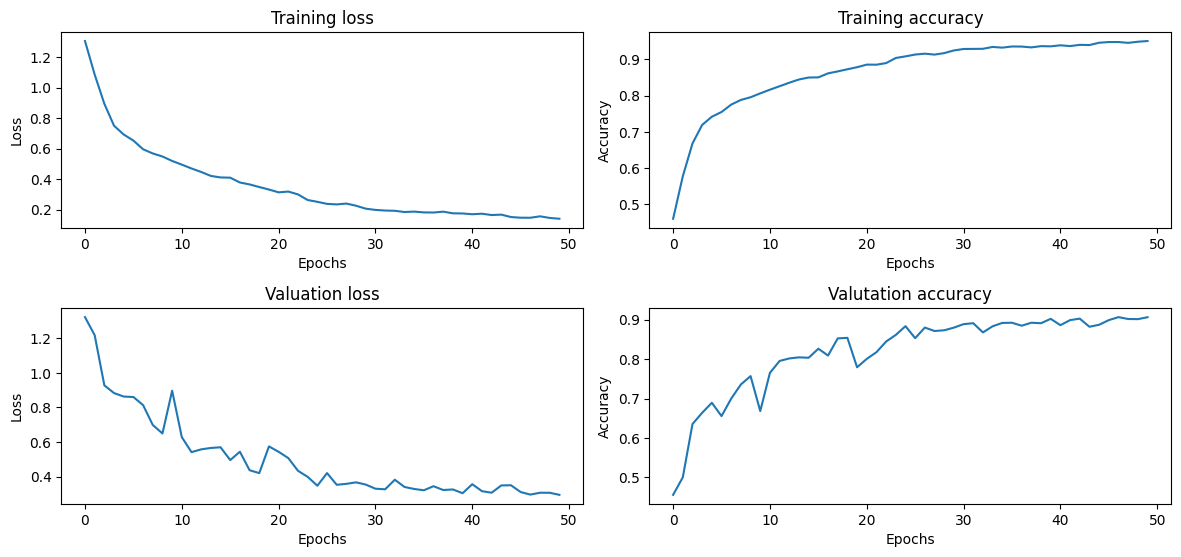

In [59]:
plt.figure(figsize=(12, 8))
plt.subplot(3, 2, 1)
plt.plot(training_loss)
plt.title(f"Training loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.subplot(3, 2, 2)
plt.plot(accuracy_train)
plt.title(f"Training accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.subplot(3, 2, 3)
plt.plot(validation_loss)
plt.title(f"Valuation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.subplot(3, 2, 4)
plt.plot(accuracy_val)
plt.title(f"Valutation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.tight_layout()
plt.show()

As expected, the training loss steadily decreases while the training accuracy increases, indicating that the model is progressively adapting to the training data.

However, the validation loss and accuracy exhibit a more irregular pattern. This behavior aligns with expectations, as the optimal parameters for a given epoch in the training set are not necessarily the best for the validation set.

Nonetheless, the overall trends in validation closely resemble those observed in training, suggesting a more than satisfactory outcome.

We proceed by evaluating the test loader, assessing key performance metrics for each class using the Classification Report. Additionally, we compute the AUC-ROC (Macro), AUC-ROC (Weighted), the confusion matrix, accuracy, and the overall precision of the model.

Classification Report:
              precision    recall  f1-score   support

           F       0.81      0.94      0.87       335
           N       0.94      0.90      0.92      3012
           S       0.77      0.84      0.80       819
           U       0.91      0.94      0.92       500
           V       0.95      0.94      0.95      2205

    accuracy                           0.91      6871
   macro avg       0.87      0.91      0.89      6871
weighted avg       0.91      0.91      0.91      6871


Confusion Matrix:


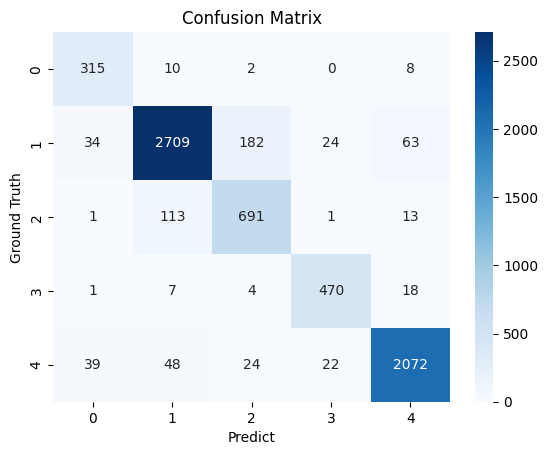


AUC-ROC (Macro): 0.9894
AUC-ROC (Weighted): 0.9873
Accuracy: 0.9106
Recall: 0.9106


In [60]:
model.eval()

# Test set predictions
all_preds = []
all_labels = []
probabilities = []  # List for saving probabilities

with torch.inference_mode():
  for batch_segments, batch_labels in test_loader:
    batch_segments = batch_segments.to(device)

    # Get logits from model
    outputs = model(batch_segments)

    # Apply softmax to get probabilities
    probs = torch.softmax(outputs, dim=1)  # Probability of each class
    probabilities.extend(probs.cpu().numpy())  # Add probabilities to the list

    # Get the above classes
    preds = torch.argmax(probs, dim=1).cpu().numpy()
    all_preds.extend(preds)
    all_labels.extend(batch_labels.numpy())

# Convert Lists to NumPy Arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
probabilities = np.array(probabilities)  # Array 2D: [num_samples, num_classes]

# 1. Classification Report (include Precision, Recall, F1-Score)
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_))

# 2. Confusion Matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(all_labels, all_preds)
unique_labels = sorted(set(all_labels))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=unique_labels, yticklabels=unique_labels)
plt.xlabel("Predict")
plt.ylabel("Ground Truth")
plt.title("Confusion Matrix")
plt.show()

# 3. AUC-ROC (requires probabilities for each class)
try:
  auc_macro = roc_auc_score(all_labels, probabilities, multi_class="ovo", average="macro")
  auc_weighted = roc_auc_score(all_labels, probabilities, multi_class="ovo", average="weighted")
  print(f"\nAUC-ROC (Macro): {auc_macro:.4f}")
  print(f"AUC-ROC (Weighted): {auc_weighted:.4f}")
except Exception as e:
  print(f"\nError in AUC calculation: {e}")

# Convert predictions and labels to PyTorch tensors
all_preds_tensor = torch.tensor(all_preds).to(device)
all_labels_tensor = torch.tensor(all_labels).to(device)

# Calculate accuracy using torchmetrics
torchmetric_accuracy = Accuracy(task="multiclass", num_classes=5).to(device)
torchmetric_recall = Recall(task="multiclass", num_classes=5).to(device)
accuracy = torchmetric_accuracy(all_preds_tensor, all_labels_tensor)
recall = torchmetric_recall(all_preds_tensor, all_labels_tensor)
print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {accuracy:.4f}")

As observed from the metrics, the results are satisfactory: despite the simplicity of the model, the overall accuracy consistently exceeds 90%.

In the medical field, recall is particularly crucial and is often prioritized over precision. This is because false negatives can have serious consequences, making it preferable to accept some false positives rather than risk missing critical cases.

Classification Report:
              precision    recall  f1-score   support

           F       0.81      0.97      0.88       374
           N       0.95      0.90      0.93      3015
           S       0.80      0.89      0.84       821
           U       0.90      0.98      0.94       513
           V       0.97      0.94      0.96      2148

    accuracy                           0.92      6871
   macro avg       0.89      0.94      0.91      6871
weighted avg       0.93      0.92      0.92      6871


Confusion Matrix:


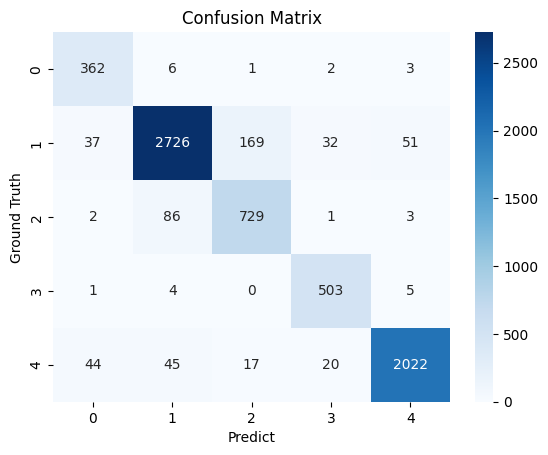


AUC-ROC (Macro): 0.9922
AUC-ROC (Weighted): 0.9901
Accuracy: 0.9230
Recall: 0.9230


In [64]:
LOADING_MODEL = True

if LOADING_MODEL:
  MODEL_PATH = Path("models")
  MODEL_NAME = "best_model_with_both_leads.pth"
  MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

  loaded_model = LSTMModel(input_size, hidden_size1, num_classes, dropout_rate).to(device)
  loaded_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH, map_location=device))

  loaded_model.eval()

  # Test set predictions
  all_preds = []
  all_labels = []
  probabilities = []  # List for saving probabilities

  with torch.inference_mode():
    for batch_segments, batch_labels in test_loader:
      batch_segments = batch_segments.to(device)

      # Get logits from loaded_model
      outputs = loaded_model(batch_segments)

      # Apply softmax to get probabilities
      probs = torch.softmax(outputs, dim=1)  # Probability of each class
      probabilities.extend(probs.cpu().numpy())  # Add probabilities to the list

      # Get the above classes
      preds = torch.argmax(probs, dim=1).cpu().numpy()
      all_preds.extend(preds)
      all_labels.extend(batch_labels.numpy())

  # Convert Lists to NumPy Arrays
  all_preds = np.array(all_preds)
  all_labels = np.array(all_labels)
  probabilities = np.array(probabilities)  # Array 2D: [num_samples, num_classes]

  # 1. Classification Report (include Precision, Recall, F1-Score)
  print("Classification Report:")
  print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_))

  # 2. Confusion Matrix
  print("\nConfusion Matrix:")
  cm = confusion_matrix(all_labels, all_preds)
  unique_labels = sorted(set(all_labels))
  sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=unique_labels, yticklabels=unique_labels)
  plt.xlabel("Predict")
  plt.ylabel("Ground Truth")
  plt.title("Confusion Matrix")
  plt.show()

  # 3. AUC-ROC (requires probabilities for each class)
  try:
    auc_macro = roc_auc_score(all_labels, probabilities, multi_class="ovo", average="macro")
    auc_weighted = roc_auc_score(all_labels, probabilities, multi_class="ovo", average="weighted")
    print(f"\nAUC-ROC (Macro): {auc_macro:.4f}")
    print(f"AUC-ROC (Weighted): {auc_weighted:.4f}")
  except Exception as e:
    print(f"\nError in AUC calculation: {e}")

  # Convert predictions and labels to PyTorch tensors
  all_preds_tensor = torch.tensor(all_preds).to(device)
  all_labels_tensor = torch.tensor(all_labels).to(device)

  # Calculate accuracy using torchmetrics
  torchmetric_accuracy = Accuracy(task="multiclass", num_classes=5).to(device)
  torchmetric_recall = Recall(task="multiclass", num_classes=5).to(device)
  accuracy = torchmetric_accuracy(all_preds_tensor, all_labels_tensor)
  recall = torchmetric_recall(all_preds_tensor, all_labels_tensor)
  print(f"Accuracy: {accuracy:.4f}")
  print(f"Recall: {accuracy:.4f}")

### **Conclusions**

This project has been highly engaging and has allowed me to acquire numerous valuable skills. Throughout its development, I explored the topic in depth by reviewing several research papers and engaging in discussions with my university peers, who provided insightful suggestions. Additionally, I expanded my professional network by interacting with new colleagues and professors. Recognizing my interest in the subject and the commitment I demonstrated, they kindly offered me access to HPC servers for training models in my future projects.

As this project reaches its conclusion, it is essential to reflect on the key insights gained, assess the limitations of my implementation, and explore potential improvements.

#### **What did I learn?**

Prior to initiating the project, my knowledge was limited to the theoretical aspects of signal processing and Deep Learning models. This project allowed me to apply these theoretical concepts in practice, experiment, and evaluate the outcomes of my decisions.

Additionally, I deepened my understanding of ECG signals and their preprocessing techniques, including denoising and segmentation. Specifically, regarding segmentation, I recognized that the initially adopted approach was ineffective and promptly revised the strategy to resolve the issue.

Finally, by analyzing training logs and model performance metrics, I improved the results through modifications to the model, optimizer adjustments, the integration of a scheduler, and the selection of optimal hyperparameters for the problem at hand.

#### **Room for Improvement**

Despite the achievements, my implementation exhibits several limitations, the acknowledgment of which is crucial for subsequent improvements:
* **Hardware limitations:** the primary constraint concerns the hardware. Lacking access to a dedicated GPU for computations, I had to rely exclusively on the GPUs provided by Google Colab. Consequently, I was unable to significantly increase certain hyperparameters, such as the number of LSTM layers and/or fully connected layers, the number of neurons in the network, the batch size, etc.
* **Signal segmentation**: the adopted segmentation strategy – extracting a single heartbeat from the ECG signal – proved functional and satisfactory for the project’s objectives. However, it remains relatively simplistic; while it may suffice for identifying some types of arrhythmia, others might be more effectively detected by analyzing a sequence of consecutive heartbeats. Therefore, adopting a sliding window segmentation approach that captures multiple heartbeats simultaneously could be considered.
* **Replacing LSTMs with Transformers:** an additional enhancement could be achieved by employing Transformer-based models, which are recognized as state-of-the-art in various applications, including time series analysis, as an alternative to LSTMs.
* **Feature extraction techniques:** finally, integrating feature extraction techniques like Convolutional Layers or Autoencoders could further optimize the model by providing additional relevant information, thereby enabling a more accurate classification of the patient’s heartbeat type.
* **Model robustness**: strengthening the model could involve determining the minimum amount of data required to achieve optimal performance. Alternatively, deliberately introducing noisy or corrupted data and evaluating the model’s ability to correctly predict heartbeats could provide valuable insights. In AI, this area of research is known as ablation studies.